# Customer Churn Prediction

In this project, we use supervised learning models to identify customers who are likely to churn in the future. Furthermore, we will analyze top factors that influence user retention. [Dataset information](https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers).

* I found out that Catboost perform an overall best prediction among different ML models.
* Age and Number of Products are top 2 features that could prevent a customer from churning. 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
bank = pd.read_csv('bank data.csv')

In [3]:
# The data has no missing value
bank.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [4]:
import pandas_profiling
pandas_profiling.ProfileReport(bank)

C:\Users\lehe2\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas_profiling\describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,14
Number of observations,10000
Total Missing (%),0.0%
Total size in memory,1.1 MiB
Average record size in memory,112.0 B
Numeric,8
Categorical,3
Boolean,3
Date,0
Text (Unique),0
Rejected,0


## 1. Exploratory Data Analysis

In [5]:
print ("Num of rows: " + str(bank.shape[0])) # row count
print ("Num of columns: " + str(bank.shape[1])) # col count
print("Churn users #: " + str(bank['Exited'].value_counts()[1]))
print("Staying users #: " + str(bank['Exited'].value_counts()[0]))

Num of rows: 10000
Num of columns: 14
Churn users #: 2037
Staying users #: 7963


In [6]:
bank = bank.drop(['RowNumber', 'CustomerId','Surname'], axis = 1)

In [7]:
num_cal = bank.select_dtypes(np.number).columns.tolist()
num_cal

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Exited']

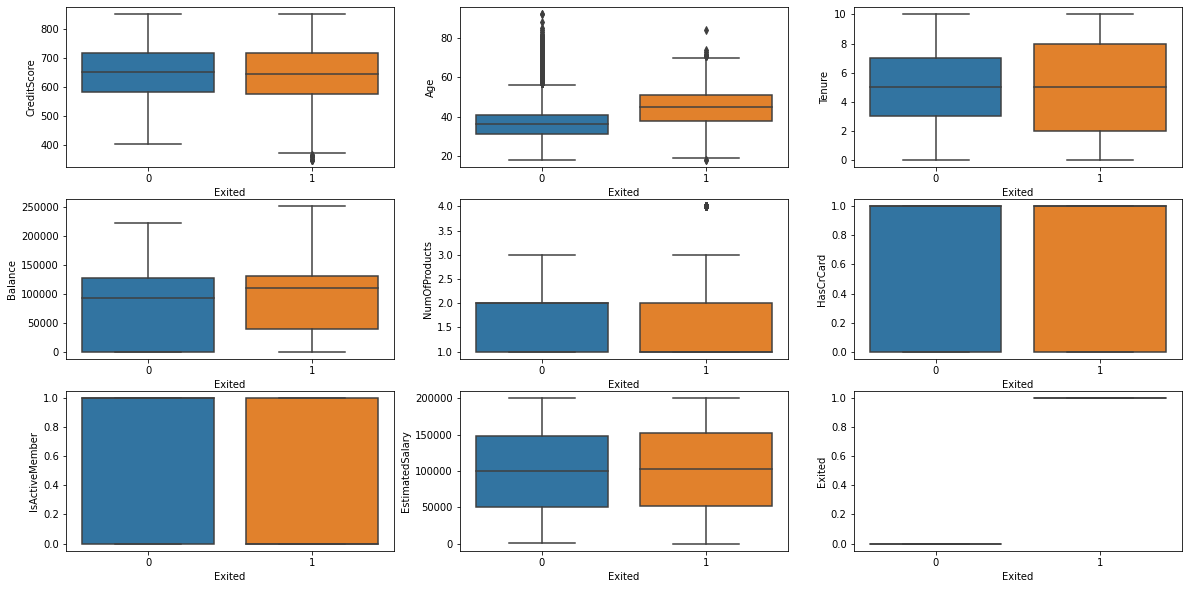

In [8]:
# Visualizing numerical features
# boxplot for numerical feature
fig ,axs = plt.subplots(3,3, figsize=[20,10])
for i, j in zip(num_cal, axs.flatten()):
    sns.boxplot(x='Exited', y = i, data = bank, ax = j)


<AxesSubplot:xlabel='IsActiveMember', ylabel='count'>

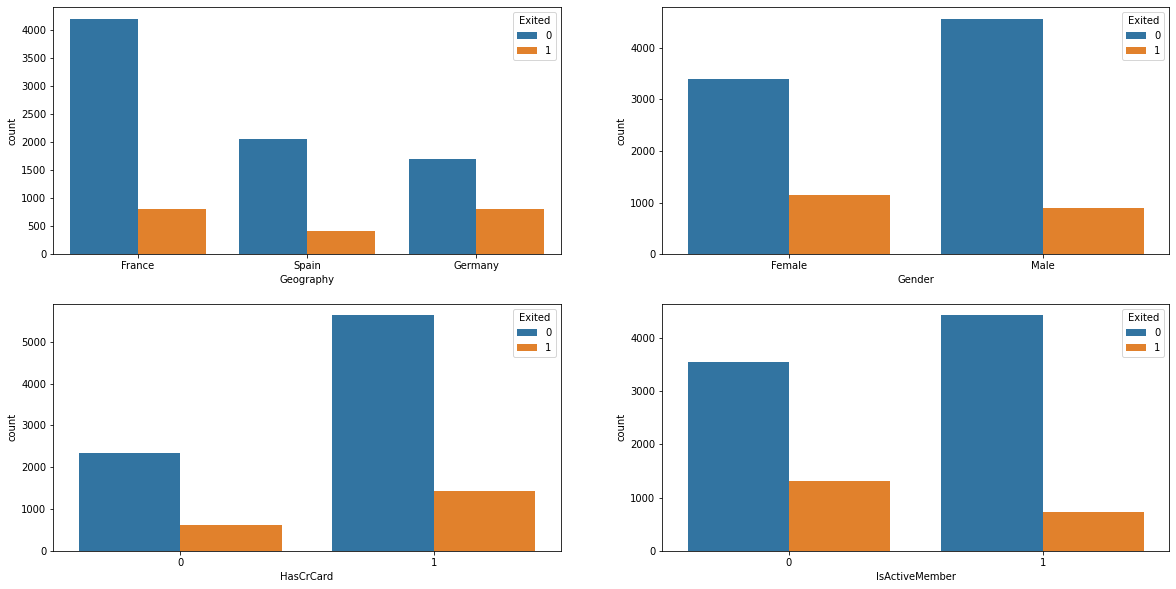

In [9]:
# understand categorical feature
# 'Geography', 'Gender'
# 'HasCrCard', 'IsActiveMember'
fig ,axss = plt.subplots(2,2, figsize=[20,10])
sns.countplot(x='Geography', hue='Exited', data=bank, ax=axss[0][0])
sns.countplot(x='Gender', hue='Exited', data=bank, ax=axss[0][1])
sns.countplot(x='HasCrCard', hue='Exited', data=bank, ax=axss[1][0])
sns.countplot(x='IsActiveMember', hue='Exited', data=bank, ax=axss[1][1])

<AxesSubplot:>

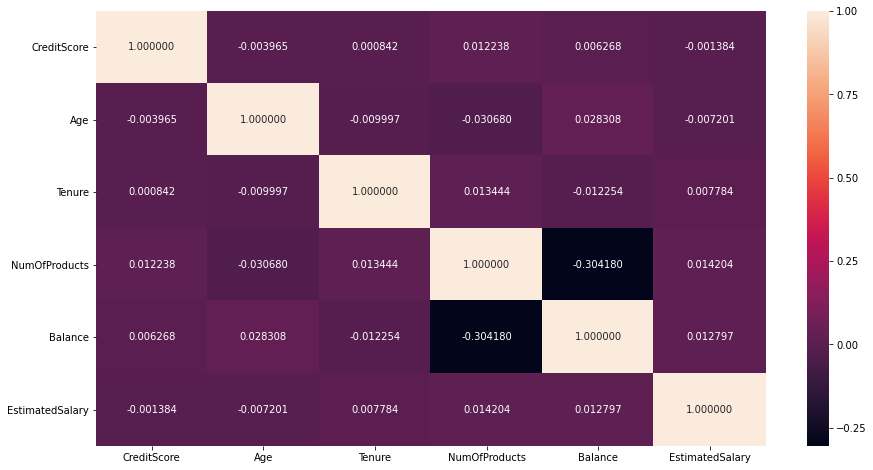

In [10]:
# correlations between features
corr_score = bank[['CreditScore', 'Age', 'Tenure', 'NumOfProducts','Balance', 'EstimatedSalary']].corr()

# show heapmap of correlations, no highly correlated columns.
plt.figure(figsize = (15,8))
sns.heatmap(corr_score, annot = True, fmt = 'f')

## 1.1OneHotEncoder

In [11]:
# Use OneHotEncoder to create dummy variables for catogerical variable
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(drop='first')

In [12]:
drop_enc = pd.DataFrame(encoder.fit_transform(bank[['Geography','Gender']]).toarray())
drop_enc.columns = encoder.get_feature_names(['Geography','Gender'])
bank_ready = bank.join(drop_enc)
bank_ready = bank_ready.drop(['Geography','Gender'], axis = 1)
bank_ready.head(3)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0.0,0.0,0.0
1,608,41,1,83807.86,1,0,1,112542.58,0,0.0,1.0,0.0
2,502,42,8,159660.80,3,1,0,113931.57,1,0.0,0.0,0.0


In [13]:
# Create X and y for model selection
X = bank_ready.drop(['Exited'], axis = 1)
y = bank_ready['Exited']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y,  test_size = 0.2, random_state = 33)

In [14]:
print(X_train.shape)
print(X_test.shape)
print(y_train.mean())
print(y_test.mean())

(8000, 11)
(2000, 11)
0.20375
0.2035


## 1.2 Principal Component Analysis

In [15]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principal = pd.DataFrame(data = principalComponents
                           , columns = ['principal component 1', 'principal component 2'])
principalDf = pd.concat([principal, y], axis = 1)
pca.explained_variance_ratio_

array([0.54118404, 0.45881465])

In [16]:
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1]
colors = ['lightblue', 'red']
for target, color in zip(targets,colors):
    indicesToKeep = principalDf['Exited'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 10)
ax.legend(targets)
ax.grid()

## 2. Model Training

### 2.1 Logistical Regression

In [17]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_train_scale = mms.fit_transform(X_train)
X_test_scale = mms.transform(X_test)

In [21]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train_scale, y_train)
logreg_pred = logreg.predict(X_test_scale)

<AxesSubplot:>

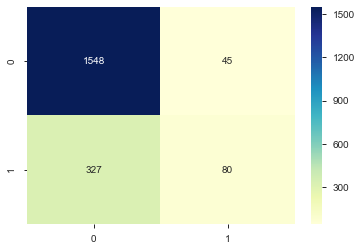

In [22]:
from sklearn.metrics import confusion_matrix, classification_report
logreg_cm = confusion_matrix(y_test, logreg_pred)
sns.heatmap(logreg_cm, annot=True,fmt='d',cmap="YlGnBu")

In [23]:
print(classification_report(y_test, logreg_pred))

              precision    recall  f1-score   support

           0       0.83      0.97      0.89      1593
           1       0.64      0.20      0.30       407

    accuracy                           0.81      2000
   macro avg       0.73      0.58      0.60      2000
weighted avg       0.79      0.81      0.77      2000



In [24]:
from sklearn import metrics
cols = ['Model', 'AUC Score', 'Precision Score', 'Recall Score','f1-score','Accuracy Score','Train Accuracy']

# creating an empty dataframe of the colums
result_tabulation = pd.DataFrame(columns = cols)

# compiling the required information
Logistic_regression_metrics = pd.Series({'Model': "Logistic regression ",
                     'AUC Score' : metrics.roc_auc_score(y_test, logreg_pred),
                 'Precision Score': metrics.precision_score(y_test, logreg_pred,average='weighted'),
                 'Recall Score': metrics.recall_score(y_test, logreg_pred,average='weighted'),
                 'f1-score':metrics.f1_score(y_test, logreg_pred,average='weighted'),
                 'Accuracy Score': metrics.accuracy_score(y_test, logreg_pred),
                 'Train Accuracy': logreg.score(X_train_scale,y_train)})



# appending our result table
result_tabulation = result_tabulation.append(Logistic_regression_metrics , ignore_index = True)

# view the result table
result_tabulation

,Model,AUC Score,Precision Score,Recall Score,f1-score,Accuracy Score,Train Accuracy
0,Logistic regression,0.584156,0.78783,0.814,0.772265,0.814,0.811375


## 2.2 Decision Tree

In [25]:
from sklearn.tree import DecisionTreeClassifier
decision_tree_classification = DecisionTreeClassifier(criterion='entropy')

# train model
decision_tree = decision_tree_classification.fit(X_train, y_train)

# predict the model using 'X_test'
decision_tree_pred = decision_tree.predict(X_test)

<AxesSubplot:>

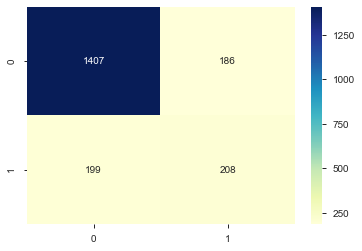

In [26]:
dt_cm = confusion_matrix(y_test, decision_tree_pred)
sns.heatmap(dt_cm, annot=True,fmt='d',cmap="YlGnBu")

In [27]:
Decision_Tree_metrics = pd.Series({'Model': "Decision Tree",
                     'AUC Score' : metrics.roc_auc_score(y_test, decision_tree_pred),
                 'Precision Score': metrics.precision_score(y_test, decision_tree_pred,average='weighted'),
                 'Recall Score': metrics.recall_score(y_test, decision_tree_pred,average='weighted'),
                 'f1-score':metrics.f1_score(y_test, decision_tree_pred,average='weighted'),
                 'Accuracy Score': metrics.accuracy_score(y_test, decision_tree_pred),
                 'Train Accuracy': decision_tree.score(X_train,y_train)})

# appending our result table
result_tabulation = result_tabulation.append(Decision_Tree_metrics , ignore_index = True)

# view the result table
result_tabulation

,Model,AUC Score,Precision Score,Recall Score,f1-score,Accuracy Score,Train Accuracy
0,Logistic regression,0.584156,0.787830,0.8140,0.772265,0.8140,0.811375
1,Decision Tree,0.697148,0.805237,0.8075,0.806329,0.8075,1.000000


## 2.3 Random Forest

In [104]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
rf_pred = rf.predict(X_test)

<AxesSubplot:>

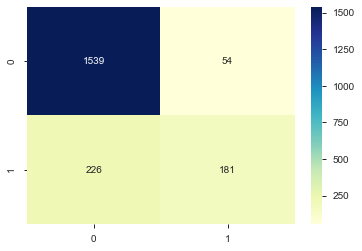

In [29]:
rf_cm = confusion_matrix(y_test, rf_pred)
sns.heatmap(rf_cm, annot = True, fmt = 'd', cmap="YlGnBu")

In [30]:
Random_forest_metrics = pd.Series({'Model': "Random Forest",
                     'AUC Score' : metrics.roc_auc_score(y_test, rf_pred),
                 'Precision Score': metrics.precision_score(y_test, rf_pred,average='weighted'),
                 'Recall Score': metrics.recall_score(y_test, rf_pred,average='weighted'),
                 'f1-score':metrics.f1_score(y_test, rf_pred,average='weighted'),
                 'Accuracy Score': metrics.accuracy_score(y_test, rf_pred),
                 'Train Accuracy': rf.score(X_train,y_train)})

# appending our result table
result_tabulation = result_tabulation.append(Random_forest_metrics , ignore_index = True)

# view the result table
result_tabulation

,Model,AUC Score,Precision Score,Recall Score,f1-score,Accuracy Score,Train Accuracy
0,Logistic regression,0.584156,0.787830,0.8140,0.772265,0.8140,0.811375
1,Decision Tree,0.697148,0.805237,0.8075,0.806329,0.8075,1.000000
2,Random Forest,0.705410,0.851250,0.8600,0.844832,0.8600,1.000000


## 2.4 AdaBoost

In [31]:
from sklearn.ensemble import AdaBoostClassifier
adaboost = AdaBoostClassifier()
# train model
adaboost.fit(X_train, y_train)
# predict the model using 'X_test'
ada_pred = adaboost.predict(X_test)

<AxesSubplot:>

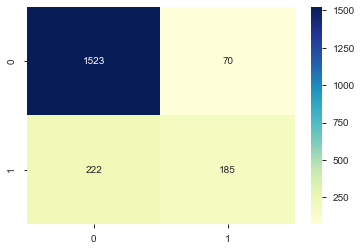

In [32]:
cm = confusion_matrix(y_test, ada_pred)
# plot a heatmap
sns.heatmap(cm, annot=True,fmt='d',cmap="YlGnBu")

In [33]:
ada_metrics = pd.Series({'Model': "Ada Boost",
                     'AUC Score' : metrics.roc_auc_score(y_test, ada_pred),
                 'Precision Score': metrics.precision_score(y_test, ada_pred,average='weighted'),
                 'Recall Score': metrics.recall_score(y_test, ada_pred,average='weighted'),
                 'f1-score':metrics.f1_score(y_test, ada_pred,average='weighted'),
                 'Accuracy Score': metrics.accuracy_score(y_test, ada_pred),
                 'Train Accuracy': adaboost.score(X_train,y_train)})

# appending our result table
result_tabulation = result_tabulation.append(ada_metrics , ignore_index = True)

# view the result table
result_tabulation

,Model,AUC Score,Precision Score,Recall Score,f1-score,Accuracy Score,Train Accuracy
0,Logistic regression,0.584156,0.787830,0.8140,0.772265,0.8140,0.811375
1,Decision Tree,0.697148,0.805237,0.8075,0.806329,0.8075,1.000000
2,Random Forest,0.705410,0.851250,0.8600,0.844832,0.8600,1.000000
3,Ada Boost,0.705302,0.842806,0.8540,0.840563,0.8540,0.858500


## 2.5 XGboost

In [67]:
from xgboost import XGBClassifier
xgboost = XGBClassifier()
# train model
xgboost.fit(X_train, y_train)
# predict the model using 'X_test'
xg_pred = xgboost.predict(X_test)

<AxesSubplot:>

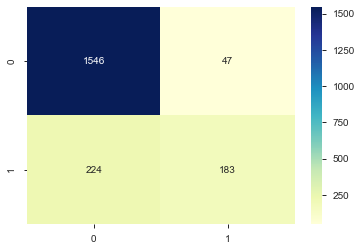

In [35]:
xgb_cm = confusion_matrix(y_test, xg_pred)
# plot a heatmap
sns.heatmap(xgb_cm, annot=True,fmt='d',cmap="YlGnBu")

In [36]:
xgb_metrics = pd.Series({'Model': "XG Boost",
                     'AUC Score' : metrics.roc_auc_score(y_test, xg_pred),
                 'Precision Score': metrics.precision_score(y_test, xg_pred,average='weighted'),
                 'Recall Score': metrics.recall_score(y_test, xg_pred,average='weighted'),
                 'f1-score':metrics.f1_score(y_test, xg_pred,average='weighted'),
                 'Accuracy Score': metrics.accuracy_score(y_test, xg_pred),
                 'Train Accuracy': xgboost.score(X_train,y_train)})

# appending our result table
result_tabulation = result_tabulation.append(xgb_metrics , ignore_index = True)

# view the result table
result_tabulation

,Model,AUC Score,Precision Score,Recall Score,f1-score,Accuracy Score,Train Accuracy
0,Logistic regression,0.584156,0.787830,0.8140,0.772265,0.8140,0.811375
1,Decision Tree,0.697148,0.805237,0.8075,0.806329,0.8075,1.000000
2,Random Forest,0.705410,0.851250,0.8600,0.844832,0.8600,1.000000
3,Ada Boost,0.705302,0.842806,0.8540,0.840563,0.8540,0.858500
4,XG Boost,0.710064,0.857615,0.8645,0.849240,0.8645,0.869875


## 2.6 CatBoost

In [65]:
from catboost import Pool, CatBoostClassifier
cbc = CatBoostClassifier(learning_rate=0.03,
                         iterations=1000,
                         early_stopping_rounds=100,
                         eval_metric = 'AUC',
                         verbose = 100
                        )
cbc.fit(X_train, y_train, 
        eval_set=(X_test, y_test), 
        plot=True
       )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8347153	best: 0.8347153 (0)	total: 17.1ms	remaining: 17.1s
100:	test: 0.8761088	best: 0.8761088 (100)	total: 840ms	remaining: 7.47s
200:	test: 0.8781771	best: 0.8784131 (166)	total: 1.83s	remaining: 7.27s
300:	test: 0.8784655	best: 0.8787200 (254)	total: 2.75s	remaining: 6.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8787200143
bestIteration = 254

Shrink model to first 255 iterations.


<AxesSubplot:>

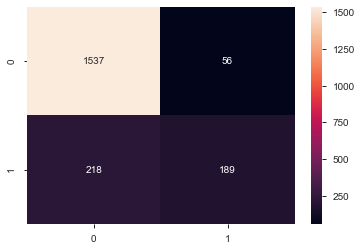

In [38]:
cbc_pred = cbc.predict(X_test)
cbc_cm = confusion_matrix(y_test, cbc_pred)
sns.heatmap(cbc_cm, annot = True, fmt = 'd')

In [39]:
cbc_metrics = pd.Series({'Model': "CatBoost",
                     'AUC Score' : metrics.roc_auc_score(y_test, cbc_pred),
                 'Precision Score': metrics.precision_score(y_test, cbc_pred,average='weighted'),
                 'Recall Score': metrics.recall_score(y_test, cbc_pred,average='weighted'),
                 'f1-score':metrics.f1_score(y_test, cbc_pred,average='weighted'),
                 'Accuracy Score': metrics.accuracy_score(y_test, cbc_pred),
                 'Train Accuracy': cbc.score(X_train,y_train)})

# appending our result table
result_tabulation = result_tabulation.append(cbc_metrics , ignore_index = True)

# view the result table
result_tabulation

,Model,AUC Score,Precision Score,Recall Score,f1-score,Accuracy Score,Train Accuracy
0,Logistic regression,0.584156,0.787830,0.8140,0.772265,0.8140,0.811375
1,Decision Tree,0.697148,0.805237,0.8075,0.806329,0.8075,1.000000
2,Random Forest,0.705410,0.851250,0.8600,0.844832,0.8600,1.000000
3,Ada Boost,0.705302,0.842806,0.8540,0.840563,0.8540,0.858500
4,XG Boost,0.710064,0.857615,0.8645,0.849240,0.8645,0.869875
5,CatBoost,0.714610,0.854547,0.8630,0.849295,0.8630,0.881125


# 3. Grid Search Method to Find best Param/Model

In [19]:
from sklearn.metrics import make_scorer, f1_score, recall_score, accuracy_score, roc_auc_score, roc_curve, precision_score
from sklearn.model_selection import GridSearchCV

In [17]:
# Create GridSearch function
def grid_search_wrapper(model, parameters, refit_score='f1_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization(refit on the best model according to refit_score)
    prints classifier performance metrics
    """

    grid_search = GridSearchCV(model, parameters, scoring='roc_auc', refit=refit_score,
                           cv=3, return_train_score=True,  n_jobs = -1)
    grid_search.fit(X_train, y_train)

    # make the predictions
    y_pred = grid_search.predict(X_test)
    y_prob = grid_search.predict_proba(X_test)[:, 1]
    
    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)
    print('---------------------------------------')
    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    cm = confusion_matrix(y_test, y_pred)
    cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
    print(cmDF)
    print('---------------------------------------')
    print("\t%s: %r" % ("roc_auc_score is: ", roc_auc_score(y_test, y_prob)))
    print("\t%s: %r" % ("f1_score is: ", f1_score(y_test, y_pred)))#string to int
    print('---------------------------------------')
    print('recall = ', float(cm[1,1]) / (cm[1,0] + cm[1,1]))
    print('precision = ', float(cm[1,1]) / (cm[1, 1] + cm[0,1]))

    return grid_search


###  3.1 Grid Search on Decision Tree

In [42]:
dt_param = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [8,12,16],
    'max_features': ['auto', 'sqrt', 'log2'],
    'class_weight' : [{ 0: 1, 1: w} for w in [0.2, 1, 20]]
}
dt = DecisionTreeClassifier()

In [43]:
grid_search_dt = grid_search_wrapper(dt, dt_param, refit_score='f1_score')

Best params for f1_score
{'class_weight': {0: 1, 1: 1}, 'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto'}
---------------------------------------

Confusion matrix of Random Forest optimized for f1_score on the test data:
        pred_0  pred_1
true_0    1527      66
true_1     236     171
---------------------------------------
	roc_auc_score is: : 0.8114863708084048
	f1_score is: : 0.531055900621118
---------------------------------------
recall =  0.4201474201474201
precision =  0.7215189873417721


In [46]:
grid_dt_pred = grid_search_dt.predict(X_test)

In [47]:
grid_search_dt_metrics = pd.Series({'Model': "Decision Tree with GridSearchCV",
                     'AUC Score' : metrics.roc_auc_score(y_test, grid_dt_pred),
                 'Precision Score': metrics.precision_score(y_test, grid_dt_pred,average='weighted'),
                 'Recall Score': metrics.recall_score(y_test, grid_dt_pred,average='weighted'),
                 'f1-score':metrics.f1_score(y_test, grid_dt_pred,average='weighted'),
                 'Accuracy Score': metrics.accuracy_score(y_test, grid_dt_pred),
                 'Train Accuracy': grid_search_dt.score(X_train,y_train)})
# appending our result table
result_tabulation = result_tabulation.append(grid_search_dt_metrics , ignore_index = True)

# view the result table
result_tabulation

,Model,AUC Score,Precision Score,Recall Score,f1-score,Accuracy Score,Train Accuracy
0,Logistic regression,0.584156,0.787830,0.8140,0.772265,0.8140,0.811375
1,Decision Tree,0.697148,0.805237,0.8075,0.806329,0.8075,1.000000
2,Random Forest,0.705410,0.851250,0.8600,0.844832,0.8600,1.000000
3,Ada Boost,0.705302,0.842806,0.8540,0.840563,0.8540,0.858500
4,XG Boost,0.710064,0.857615,0.8645,0.849240,0.8645,0.869875
5,CatBoost,0.714610,0.854547,0.8630,0.849295,0.8630,0.881125
6,Decision Tree with GridSearchCV,0.689358,0.836707,0.8490,0.832894,0.8490,0.864363


###  3.2 Grid Search on RandomForest

In [48]:
rf_param = {
    'max_depth': [10, 20],
    'n_estimators': [200, 700],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy'],
    'class_weight' : [{ 0: 1, 1: w} for w in [0.2, 1, 20]]
}
rf = RandomForestClassifier(random_state = 33)

In [49]:
grid_search_rf = grid_search_wrapper(rf, rf_param, refit_score='f1_score')

Best params for f1_score
{'class_weight': {0: 1, 1: 1}, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 700}
---------------------------------------

Confusion matrix of Random Forest optimized for f1_score on the test data:
        pred_0  pred_1
true_0    1548      45
true_1     234     173
---------------------------------------
	roc_auc_score is: : 0.8732476698578392
	f1_score is: : 0.5536
---------------------------------------
recall =  0.4250614250614251
precision =  0.7935779816513762


In [50]:
grid_rf_pred = grid_search_rf.predict(X_test)

In [51]:
grid_search_rf_metrics = pd.Series({'Model': "Random Forest with GridSearchCV",
                     'AUC Score' : metrics.roc_auc_score(y_test, grid_rf_pred),
                 'Precision Score': metrics.precision_score(y_test, grid_rf_pred,average='weighted'),
                 'Recall Score': metrics.recall_score(y_test, grid_rf_pred,average='weighted'),
                 'f1-score':metrics.f1_score(y_test, grid_rf_pred,average='weighted'),
                 'Accuracy Score': metrics.accuracy_score(y_test, grid_rf_pred),
                 'Train Accuracy': grid_search_rf.score(X_train,y_train)})
# appending our result table
result_tabulation = result_tabulation.append(grid_search_rf_metrics , ignore_index = True)

# view the result table
result_tabulation

,Model,AUC Score,Precision Score,Recall Score,f1-score,Accuracy Score,Train Accuracy
0,Logistic regression,0.584156,0.787830,0.8140,0.772265,0.8140,0.811375
1,Decision Tree,0.697148,0.805237,0.8075,0.806329,0.8075,1.000000
2,Random Forest,0.705410,0.851250,0.8600,0.844832,0.8600,1.000000
3,Ada Boost,0.705302,0.842806,0.8540,0.840563,0.8540,0.858500
4,XG Boost,0.710064,0.857615,0.8645,0.849240,0.8645,0.869875
5,CatBoost,0.714610,0.854547,0.8630,0.849295,0.8630,0.881125
6,Decision Tree with GridSearchCV,0.689358,0.836707,0.8490,0.832894,0.8490,0.864363
7,Random Forest with GridSearchCV,0.698406,0.853402,0.8605,0.843314,0.8605,0.954383


## 3.3 Gird search on XGboost

In [52]:
xg_param = {
    'max_depth': [2, 6, 10],
    'eta': [0.5, 0.3, 0.1],
    'sampling_method' : ['uniform', 'gradient_based'],
    'subsample': [0.8, 1],
    'lambda' : [1, 5, 10]
}
xgboost = XGBClassifier()

In [53]:
grid_search_xgb = grid_search_wrapper(xgboost, xg_param, refit_score='f1_score')

Best params for f1_score
{'eta': 0.5, 'lambda': 1, 'max_depth': 2, 'sampling_method': 'uniform', 'subsample': 0.8}
---------------------------------------

Confusion matrix of Random Forest optimized for f1_score on the test data:
        pred_0  pred_1
true_0    1542      51
true_1     227     180
---------------------------------------
	roc_auc_score is: : 0.8666833243104429
	f1_score is: : 0.5642633228840125
---------------------------------------
recall =  0.44226044226044225
precision =  0.7792207792207793


In [54]:
grid_xgb_pred = grid_search_xgb.predict(X_test)

In [22]:
grid_search_xgb_metrics = pd.Series({'Model': "XGBoost with GridSearchCV",
                     'AUC Score' : metrics.roc_auc_score(y_test, grid_xgb_pred),
                 'Precision Score': metrics.precision_score(y_test, grid_xgb_pred,average='weighted'),
                 'Recall Score': metrics.recall_score(y_test, grid_xgb_pred,average='weighted'),
                 'f1-score':metrics.f1_score(y_test, grid_xgb_pred,average='weighted'),
                 'Accuracy Score': metrics.accuracy_score(y_test, grid_xgb_pred),
                 'Train Accuracy': grid_search_xgb.score(X_train,y_train)})
# appending our result table
result_tabulation = result_tabulation.append(grid_search_xgb_metrics , ignore_index = True)

# view the result table
result_tabulation

NameError: name 'result_tabulation' is not defined

## 3.4 Grid Search on Catboost

In [56]:
catboost_param = {
    'loss_function':['Logloss'],
    'eval_metric':['AUC'],
    'learning_rate': [0.03, 0.1],
    'depth': [6, 16, 20],
    'l2_leaf_reg': [5, 10],
    'verbose': [200],
    'iterations': [400]
}
cbc = CatBoostClassifier()

In [57]:
grid_search_cat = grid_search_wrapper(cbc, catboost_param, refit_score='recall_score')

0:	total: 15.1ms	remaining: 6.01s
200:	total: 2.21s	remaining: 2.19s
399:	total: 4.62s	remaining: 0us
Best params for recall_score
{'depth': 6, 'eval_metric': 'AUC', 'iterations': 400, 'l2_leaf_reg': 10, 'learning_rate': 0.03, 'loss_function': 'Logloss', 'verbose': 200}
---------------------------------------

Confusion matrix of Random Forest optimized for recall_score on the test data:
        pred_0  pred_1
true_0    1536      57
true_1     212     195
---------------------------------------
	roc_auc_score is: : 0.8780506238133357
	f1_score is: : 0.5918057663125948
---------------------------------------
recall =  0.47911547911547914
precision =  0.7738095238095238


In [58]:
grid_cat_pred = grid_search_cat.predict(X_test)

In [59]:
grid_search_cat_metrics = pd.Series({'Model': "CatBoost with GridSearchCV",
                     'AUC Score' : metrics.roc_auc_score(y_test, grid_cat_pred),
                 'Precision Score': metrics.precision_score(y_test, grid_cat_pred,average='weighted'),
                 'Recall Score': metrics.recall_score(y_test, grid_cat_pred,average='weighted'),
                 'f1-score':metrics.f1_score(y_test, grid_cat_pred,average='weighted'),
                 'Accuracy Score': metrics.accuracy_score(y_test, grid_cat_pred),
                 'Train Accuracy': grid_search_cat.score(X_train,y_train)})
# appending our result table
result_tabulation = result_tabulation.append(grid_search_cat_metrics , ignore_index = True)

# view the result table
result_tabulation

,Model,AUC Score,Precision Score,Recall Score,f1-score,Accuracy Score,Train Accuracy
0,Logistic regression,0.584156,0.787830,0.8140,0.772265,0.8140,0.811375
1,Decision Tree,0.697148,0.805237,0.8075,0.806329,0.8075,1.000000
2,Random Forest,0.705410,0.851250,0.8600,0.844832,0.8600,1.000000
3,Ada Boost,0.705302,0.842806,0.8540,0.840563,0.8540,0.858500
4,XG Boost,0.710064,0.857615,0.8645,0.849240,0.8645,0.869875
5,CatBoost,0.714610,0.854547,0.8630,0.849295,0.8630,0.881125
6,Decision Tree with GridSearchCV,0.689358,0.836707,0.8490,0.832894,0.8490,0.864363
7,Random Forest with GridSearchCV,0.698406,0.853402,0.8605,0.843314,0.8605,0.954383
8,XGBoost with GridSearchCV,0.705123,0.852864,0.8610,0.845466,0.8610,0.868460
9,CatBoost with GridSearchCV,0.721667,0.857370,0.8655,0.852802,0.8655,0.906525


Text(0.5, 1.0, 'XGboost features importance:')

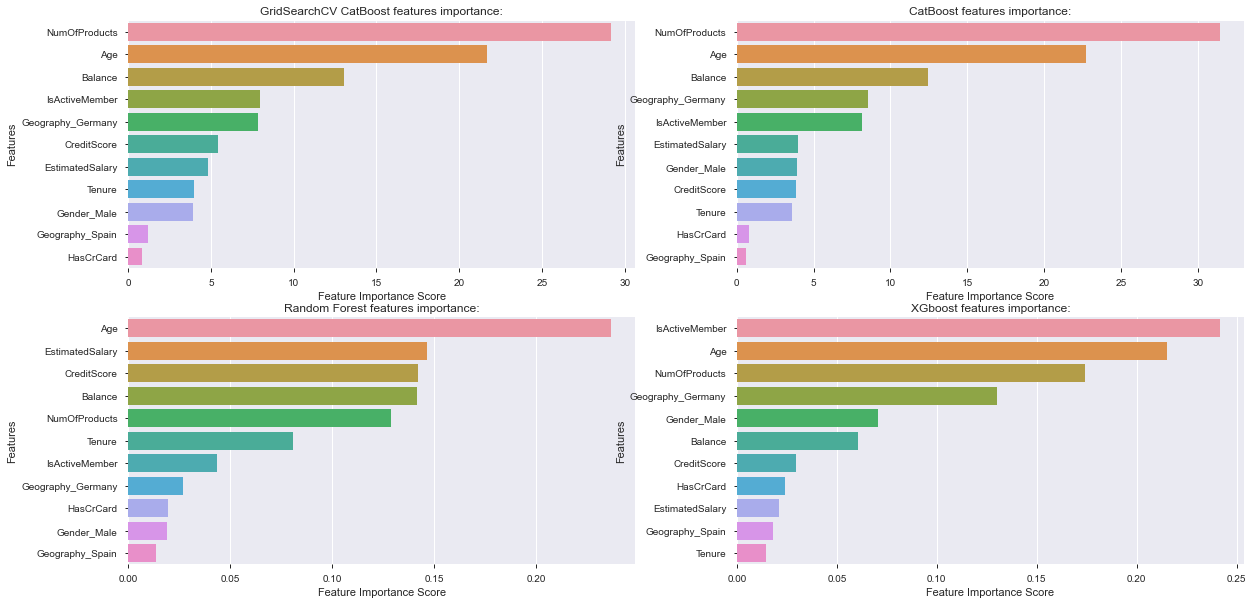

In [116]:
# plot feature importance for top 4 models based on f1-score
fig = plt.figure(figsize = (20, 10))
# features importance for catboost
ax0=fig.add_subplot(221)
grid_cat_importance = grid_search_cat.best_estimator_.feature_importances_
feature_imp = pd.Series(grid_cat_importance,index=X_train.columns).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index, ax = ax0)
ax0.set_xlabel('Feature Importance Score')
ax0.set_ylabel('Features')
ax0.set_title("GridSearchCV CatBoost features importance:")

# features importance for Catboost
ax1=fig.add_subplot(222)
cbc_importance = cbc.get_feature_importance(prettified=True)
sns.barplot(x='Importances', y='Feature Id', data=cbc_importance, ax = ax1)
ax1.set_xlabel('Feature Importance Score')
ax1.set_ylabel('Features')
ax1.set_title("CatBoost features importance:")

# features importance for random forest
ax2=fig.add_subplot(223)
rf_importance = rf.feature_importances_
feature_imp = pd.Series(rf_importance,index=X_train.columns).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index, ax = ax2)
ax2.set_xlabel('Feature Importance Score')
ax2.set_ylabel('Features')
ax2.set_title("Random Forest features importance:")

# features importance for XGboost
ax3=fig.add_subplot(224)
xgb_importance = xgboost.feature_importances_
feature_imp = pd.Series(xgb_importance,index=X_train.columns).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index, ax = ax3)
ax3.set_xlabel('Feature Importance Score')
ax3.set_ylabel('Features')
ax3.set_title("XGboost features importance:")


